In [1]:
import os
import glob
from collections import OrderedDict, defaultdict
import math
from functools import reduce
import operator
import requests
import urllib
import shutil
from typing import Optional, Tuple, Dict, Any

import tqdm
from bs4 import BeautifulSoup
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import cv2


RAW_KNOWN_FLAG_PATTERN = './raw_known_flags/*'
RAW_UNKNOWN_FLAG_PATTERN = './raw_unknown_flags/*'

In [2]:
# Helper functions for downloading and exploring flag data
def scrape_cia_factbook_flags() -> None:
    """
    Download every flag of the world from the CIA factbook
    """
    
    flags_url = 'https://www.cia.gov/library/publications/the-world-factbook/docs/'
    # Download CIA factbook flags page
    html = requests.get(flags_url + 'flagsoftheworld.html').content
    soup = BeautifulSoup(html)
    
    # Scrape CIA factbook for image links and flag names
    flags = soup.findAll('div', {'class': 'flag-image'})
    flag_dict = {}
    for flag in flags:
        data = [i for i in flag][1].attrs
        flag_dict[data['title']] = data['src']
        
    # Download pictures from cia factbook
    flag_pic_dict = {}
    for flag_name, flag_url in tqdm.tqdm(flag_dict.items()):
        flag_pic_dict[flag_name] = urllib.request.urlretrieve(flags_url + flag_url, f'./raw_known_flags/{flag_name.replace(" ", "_").lower()}.gif')
                                                              
def get_sorted_image(path: str, i: Optional[Image.Image] = None) -> Tuple['np.array', Image.Image]:
    """
    Opens the image and sorts the pixels by color so that similar colors will be clustered.
    
    
    This allows for easy comparison between images who's pixels have been jumbled
    
    Input: Takes the path of an image.
           Optionally allows for another image which the image will be scaled to
    Output: np.array of the sorted image and Pillow.Image version of the original unsorted image
    """
    
    # Images come in gif form Convert all to standard rgb images
    gif_image = Image.open(path)

    mypalette = gif_image.getpalette()
    reg_image = Image.new('RGB', gif_image.size)
    reg_image.paste(gif_image)
    
    if i:
        reg_image = reg_image.resize(i.size)
    
    # Convert images to a sorted list of their colors
    colors = reg_image.getdata()
    colors = sorted(list(colors))
    
    return colors, reg_image

def get_viewable_sorted(path: str, image: Optional[Image.Image] = None) -> Image.Image:
    """
    Input: Takes the path of an image
    Output: Returns a Pillow.Image object of the image that has had its pixels sorted by color
    """
    raw_sorted, im = get_sorted_image(path, image)
    
    im2 = Image.new(im.mode, im.size)
    im.putdata(raw_sorted)
    
    return im

def compare_images(image1: Image.Image, image2: Image.Image) -> float:
    """
    Takes the rms value between two images allowing images to be compared for similarity
    
    Input: 2 PIL.Images
    Output: Numeric value of similarity. Lower numbers means more similar
    """
    h1 = image1.histogram()
    h2 = image2.histogram()
    
    rms = math.sqrt(reduce(operator.add,
        map(lambda a,b: (a-b)**2, h1, h2))/len(h1))
    
    return rms

def sort_dict_by_value(d: Dict[str, Any]):
    """
    Take a dictionary and sort it by its values
    """
    return {k:v for k,v in sorted(d.items(), key=lambda item: item[1])}

def plot_candidates(unknown_path: str, 
                    rankings: Dict[str,Any], 
                    max_candidates: int = 36, 
                    figsize: Tuple[int,int] = (20,20)):
    """
    Plot grid of flags to visually compare similarities
    """
    dim = int(np.sqrt(max_candidates))

    fig, ax = plt.subplots(dim, dim, figsize=figsize)
        
    unknown_image = get_viewable_sorted(unknown_path)
    ax[0][0].imshow(unknown_image)
    ax[0][0].set_title(f'Unknown Flag: {unknown_path.split("/")[-1].split(".")[0]}')

    for i, val in enumerate(sort_dict_by_value(rankings).items(), 1):
        path, rme = val
        country = path.split('/')[-1].split('.')[0] 
        
        image = get_viewable_sorted(path)
        image = image.resize(unknown_image.size)
        ax[i%dim][i//dim].imshow(image)
        ax[i%dim][i//dim].set_title(f'{country}:{int(rme)}')

        if i >= max_candidates - 1:
            break

In [3]:
# Compare the flags to eachother and plot the rms similarity rankings
similarity_rankings = defaultdict(dict)
for unknown_path in glob.glob('./raw_unknown_flags/*'):
    print("Processing: ", unknown_path)
    unknown_image = get_viewable_sorted(unknown_path)
    for known_path in glob.glob('./raw_known_flags/*'):
        known_image = get_viewable_sorted(known_path, unknown_image)
        
        rms = compare_images(unknown_image, known_image)
        
        similarity_rankings[unknown_path][known_path] = rms
        

Processing:  ./raw_unknown_flags/flag_b.png
Processing:  ./raw_unknown_flags/flag_c.png
Processing:  ./raw_unknown_flags/flag_a.png


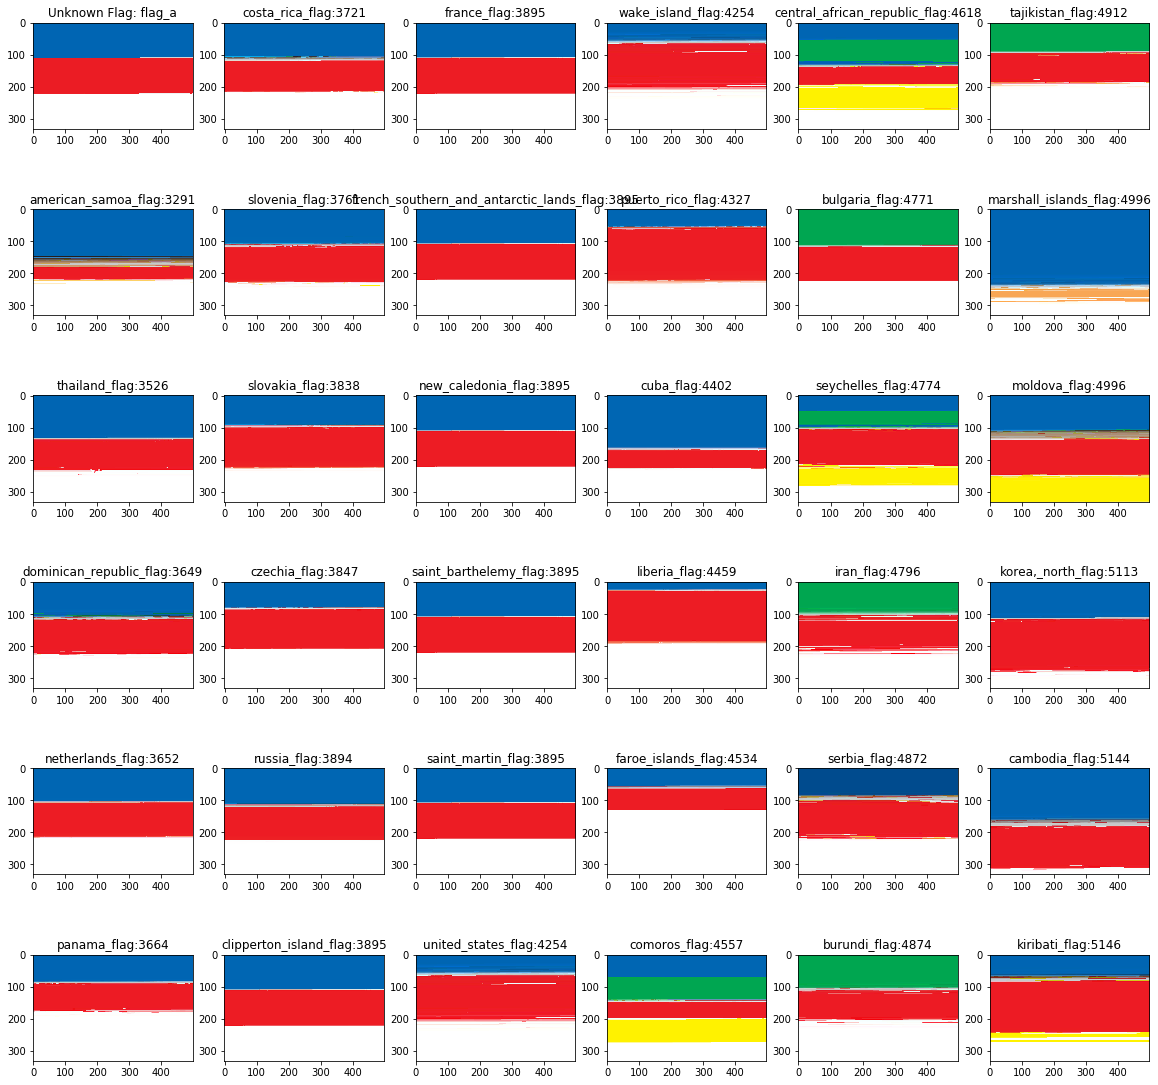

In [4]:
# Difficult to tell which flag is the closest match 
# Looks like a close tie between france, the netherlands, and russia which makes sense since they all have equal parts red white and blue.
# Most of these other flags that match are based on the french flag. 
# Since it has the best ranking out of all of them and theres no real reason to differentiate lets choose the french flag as our choice for flag A
plot_candidates('./raw_unknown_flags/flag_a.png', similarity_rankings['./raw_unknown_flags/flag_a.png'])

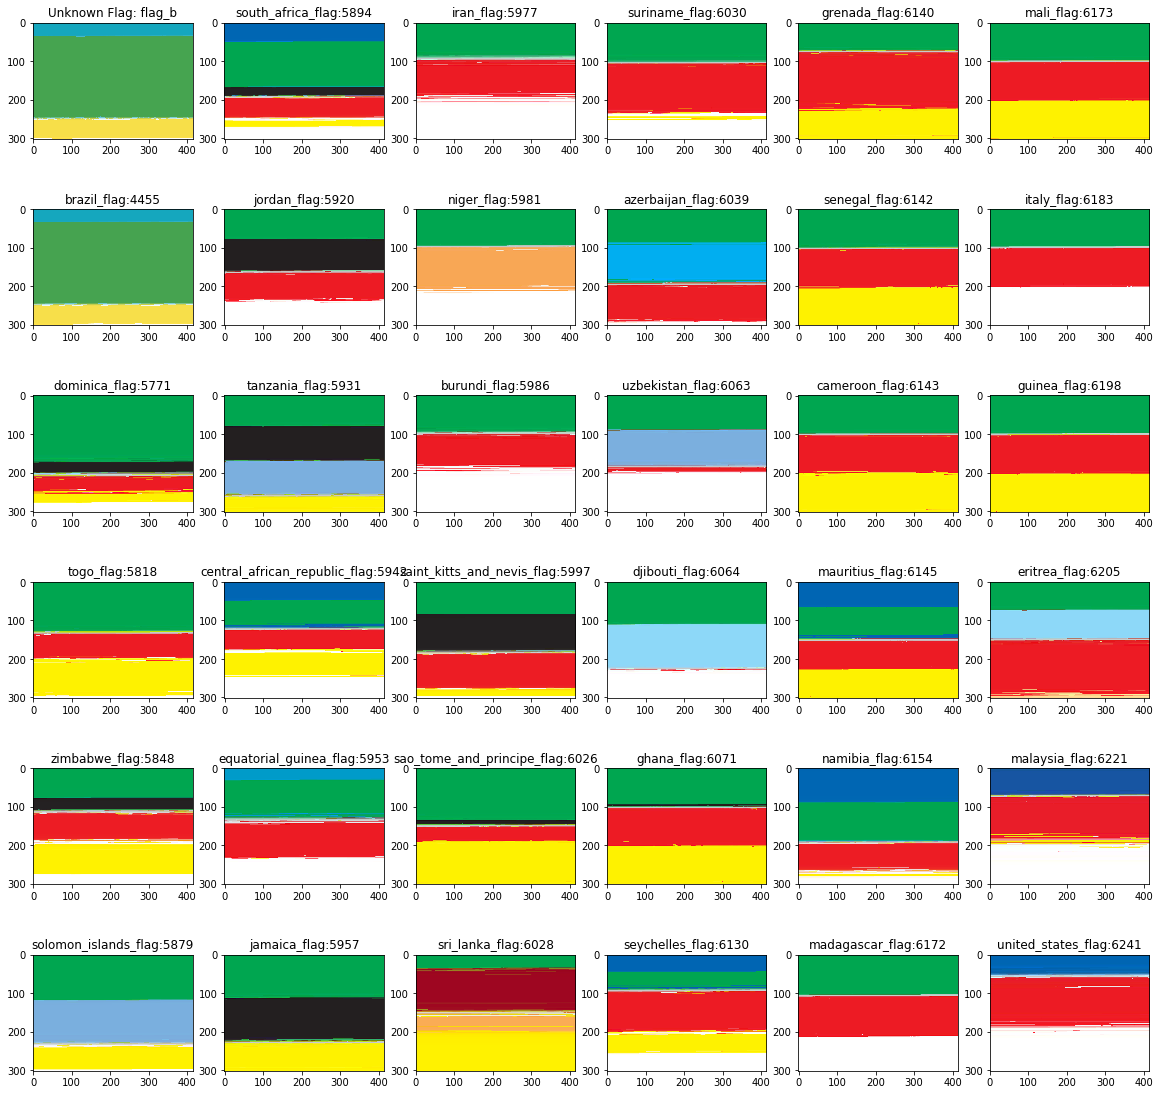

In [5]:
# The Brazilian flag is the only one that comes even close. This is an obvious choice
plot_candidates('./raw_unknown_flags/flag_b.png', similarity_rankings['./raw_unknown_flags/flag_b.png'])

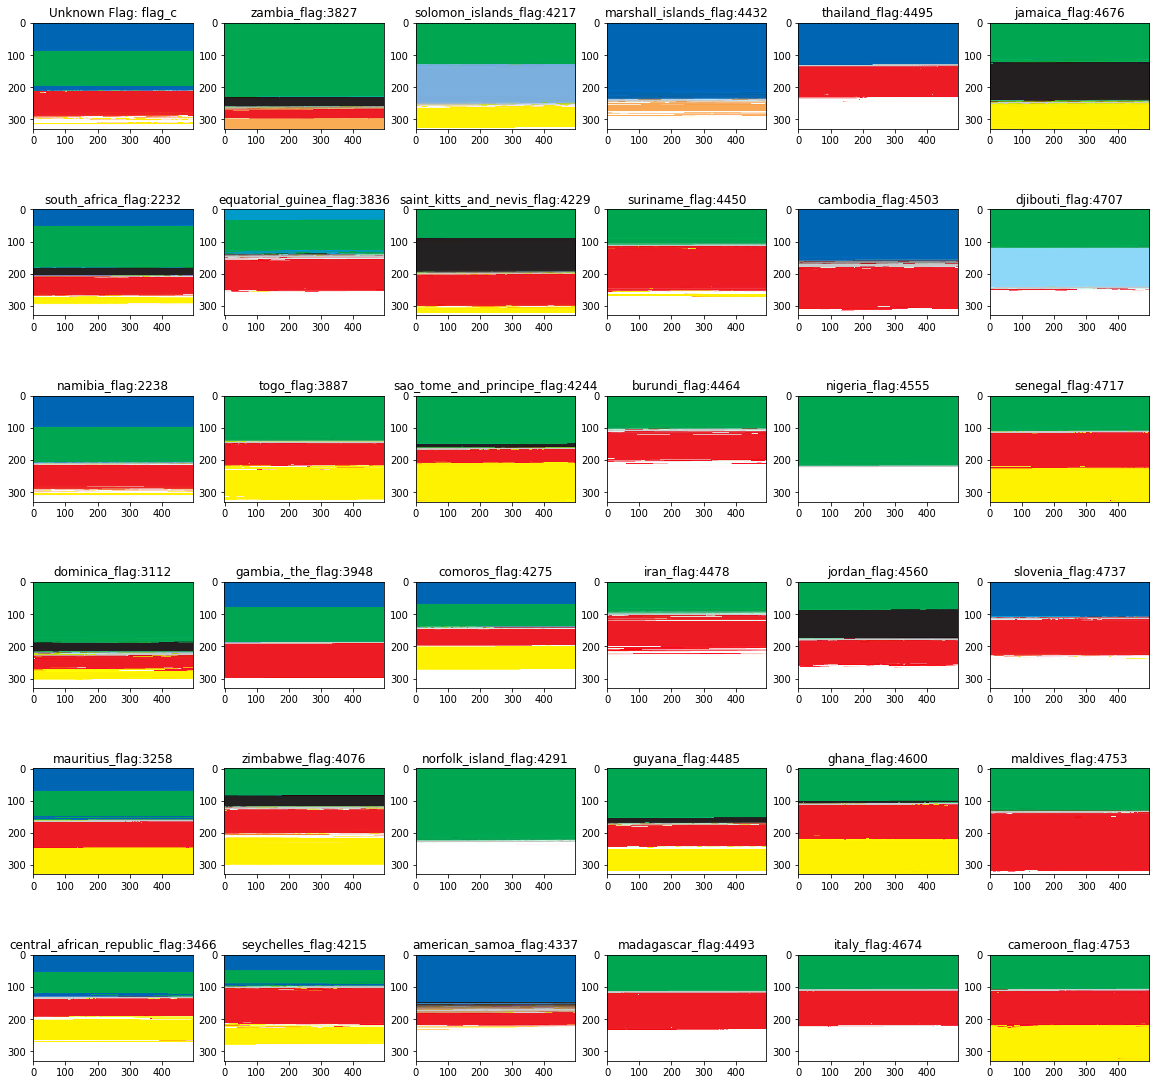

In [6]:
# Nambia flag seems like the most likely option. Other flags either seem to have the wrong colors or wrong proportions
plot_candidates('./raw_unknown_flags/flag_c.png', similarity_rankings['./raw_unknown_flags/flag_c.png'])